# YaRN

在 NTK-Aware RoPE 中, 实现了维度动态插值的方法，即随着维度增加其内插强度增强。

但 NTK 方法的问题（1） 在于, 高频仍然是有内插的（尽管幅度小），严格来看，NTK 并没有 100% 做到保留高频的效用。

高频一般影响近距离建模序列的位置表示，如果破坏了高频，那么预训练的近距离破坏，就导致使用 PI 或 NTK 方法，虽然拓展了 long context 仍然效果不理想。

一个反直觉的事实是：**保留** short-context 位置表示能力，才是保证拓展 long-context 的前提。

（2）在 NTK 中, 无法做到外推。 在 YaRN 之前的方法，所谓高频外推是虚的、训练后才能达到目标context 也是虚的（正确的外推是模型训16k，能推理32k）

而 YaRN 能够达到的关键特性是：

1. 100% 保高频, YaRN采用分段处理手段，从内插视角对角度，高频不内插，低频内插，高频与低频之间插值
2. 外推 2x 的训练长度（训短推长）

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

## RoPE 的内插视角

In [2]:
dim = 128

def YaRN(d, s):
    high_req_id = int(d*0.2)
    low_req_id = int(d*0.8)
    PI_scale = torch.ones(d)
    PI_scale[low_req_id:] = s

    smooth = (torch.arange(low_req_id-high_req_id)+1) / (low_req_id-high_req_id) # 0～1
    PI_scale[high_req_id:low_req_id] = smooth * s + (1-smooth) * 1 # 插值
    
    return PI_scale

base = 10000.0
s = 10.0
I_Yarn = YaRN(dim//2, s)

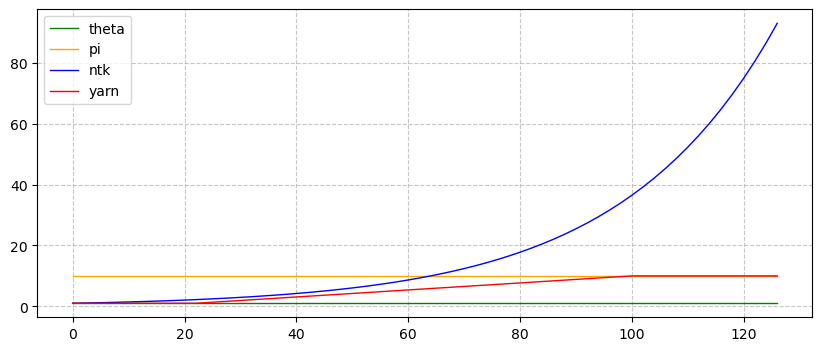

In [3]:
# 内插强度
import matplotlib.pyplot as plt

I_rope = torch.ones(dim//2)
I_PI = torch.ones(dim//2) * s

i = torch.arange(0, dim, 2)
I_NTK = (s) ** (2 * i / dim)

plt.figure(figsize=(10, 4))
plt.plot(i.tolist(), I_rope.tolist(), 'g', linewidth=1, label='theta')
plt.plot(i.tolist(), I_PI.tolist(), 'orange', linewidth=1, label='pi')
plt.plot(i.tolist(), I_NTK.tolist(), 'blue', linewidth=1, label='ntk')
plt.plot(i.tolist(), I_Yarn.tolist(), 'r', linewidth=1, label='yarn')
plt.grid(True, linestyle='--', alpha=0.7)
# plt.ylim(0,1.2)
plt.legend()
plt.show()

YaRN 的核心思想介于 原始RoPE 与 PI 之间的过渡

1. 高频外推(即不做任何处理）
2. 低频内插(拓展 long-context 理解能力）
3. 中间段（ 内插强度 1~s 之间插值 ), 使得高低频角度变化平缓

基于此，RoPE、PI、NTK-RoPE、YaRN 四种位置编码，就是采用了不同的角度内插策略。

YaRN 实现的关键在于（1）如何找到高低频分段点 （2）如何进行高低频内插强度插值

## YaRN 实现

YaRN 包含三个关键优化：

1. 分段 RoPE
2. Dynamic Scaling
3. Attention score yarn-rescale

In [4]:
def _apply_rotary_emb(
    x: torch.Tensor,
    cos: torch.Tensor,
    sin: torch.Tensor,
) -> torch.Tensor:
    seq_len, _, _ = x.size()
    cos = cos[:seq_len,:]
    sin = sin[:seq_len,:]

    cos = cos.unsqueeze(-2).to(x.dtype)
    sin = sin.unsqueeze(-2).to(x.dtype)

    x1, x2 = torch.chunk(x, 2, dim=-1)
    o1 = x1 * cos - x2 * sin
    o2 = x2 * cos + x1 * sin
    return torch.cat((o1, o2), dim=-1)
    
class YaRN(torch.nn.Module):
    def __init__(
        self,
        head_dim: int,
        base: int,
        dtype: torch.dtype,
        initial_context_length: int = 4096,
        scaling_factor: float = 1.0,
        ntk_alpha: float = 1.0,
        ntk_beta: float = 32.0,
        device: torch.device | None = None,
    ) -> None:
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        self.dtype = dtype
        self.initial_context_length = initial_context_length
        self.scaling_factor = scaling_factor
        self.ntk_alpha = ntk_alpha
        self.ntk_beta = ntk_beta
        self.device = device

    def _compute_concentration_and_inv_freq(self) -> torch.Tensor:
        """See YaRN paper: https://arxiv.org/abs/2309.00071"""
        freq = self.base ** (
            torch.arange(0, self.head_dim, 2, dtype=torch.float, device=self.device)
            / self.head_dim
        )
        
        self.scaling_factor = max( 1, self.cur_context_length  / self.initial_context_length)

        # if self.cur_context_length > self.initial_context_length:
        #     self.initial_context_length = self.cur_context_length
        
        if self.scaling_factor > 1.0:
            
            # 3️⃣ YaRN:  Re-Scale
            # concentration: \sqrt{1/t} = 0.1 log(s) + 1.0
            # t = 1/(0.1log(s)+1.0)^2
            concentration = (
                0.1 * math.log(self.scaling_factor) + 1.0
            )  # YaRN concentration
            print('t:',  1/concentration**2)

            d_half = self.head_dim / 2

            # 1️⃣ YaRN:  NTK by parts
            low = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_beta * 2 * math.pi))
                / math.log(self.base)
            )
            high = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_alpha * 2 * math.pi))
                / math.log(self.base)
            )
            assert 0 < low < high < d_half - 1
            print('low, high:', low, high)

            interpolation = 1.0 / (self.scaling_factor * freq)
            extrapolation = 1.0 / freq

            ramp = (
                torch.arange(d_half, dtype=torch.float32, device=freq.device) - low
            ) / (high - low)
            mask = 1 - ramp.clamp(0, 1)

            inv_freq = interpolation * (1 - mask) + extrapolation * mask
        else:
            concentration = 1.0
            inv_freq = 1.0 / freq

        return concentration, inv_freq

    def _compute_cos_sin(self, num_tokens: int):
        concentration, inv_freq = self._compute_concentration_and_inv_freq()
        print('YaRN Re-Scale:',  concentration)
        t = torch.arange(num_tokens, dtype=torch.float32, device=self.device)
        freqs = torch.einsum("i,j->ij", t, inv_freq)
        cos = freqs.cos() * concentration
        sin = freqs.sin() * concentration
        return cos, sin

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # 2️⃣ YaRN Dynamic-Scaling 技术
        num_tokens = query.shape[0]
        self.cur_context_length = num_tokens
        cos, sin = self._compute_cos_sin(num_tokens) # 随 seq_len 增长而增长

        query_shape = query.shape
        query = query.view(num_tokens, -1, self.head_dim)
        query = _apply_rotary_emb(query, cos, sin)
        query = query.reshape(query_shape)

        key_shape = key.shape
        key = key.view(num_tokens, -1, self.head_dim)
        key = _apply_rotary_emb(key, cos, sin)
        key = key.reshape(key_shape)
        return query, key

In [5]:
head_dim = 512
base = 10000.0
batch_size = 8
seq_len = 32

Q = torch.randn(seq_len, head_dim)
K = torch.randn(seq_len, head_dim)

yarn = YaRN(head_dim = head_dim, 
            base = 10000.0, 
            dtype=torch.float32, 
            scaling_factor=10, 
            initial_context_length=4096)
q_rope, k_rope = yarn.forward(Q, K)
L = 1024
for i in range(10):
    L *= 2
    print(L)
    Q = torch.randn(L, head_dim)
    K = torch.randn(L, head_dim)
    q_rope, k_rope = yarn.forward(Q, K)
    del Q
    del K
    del q_rope
    del k_rope
    print('-'*100)

YaRN Re-Scale: 1.0
2048
YaRN Re-Scale: 1.0
----------------------------------------------------------------------------------------------------
4096
YaRN Re-Scale: 1.0
----------------------------------------------------------------------------------------------------
8192
t: 0.8745585923764103
low, high: 83.7779264825442 180.1075250950182
YaRN Re-Scale: 1.0693147180559945
----------------------------------------------------------------------------------------------------
16384
t: 0.7713210535693215
low, high: 83.7779264825442 180.1075250950182
YaRN Re-Scale: 1.138629436111989
----------------------------------------------------------------------------------------------------
32768
t: 0.6853403266295983
low, high: 83.7779264825442 180.1075250950182
YaRN Re-Scale: 1.2079441541679836
----------------------------------------------------------------------------------------------------
65536
t: 0.6129741270046833
low, high: 83.7779264825442 180.1075250950182
YaRN Re-Scale: 1.277258872223978

## 波长与旋转圈数

波长：维度 i 上, $mtheta_i$ 能够首度到达 $2\pi$ 时的长度

$$
 \lambda_i = \frac{2\pi}{\theta_i} = 2\pi b^{\frac{2(i-1)}{d}} 
$$

旋转圈数： 目标长度是 L， 那么 $r_i$ 表示各维度，能够旋转的圈数
$$
r_i = \frac{L}{\lambda_i} = \frac{L}{ 2\pi b^{\frac{2(i-1)}{d}}} \\
$$

分段点，旋转圈数为 32 对应的维度为高频点， 旋转圈数 1 对应的维度为 低频点。 

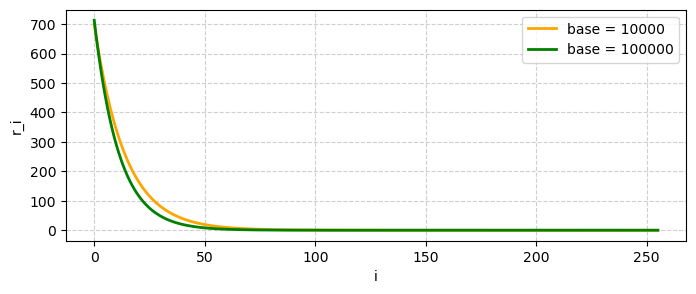

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 设置参数
d = 256
m = 4096
base = 10000

# 创建横坐标
# x = np.arange(0, d)
x = torch.arange(0, d)
lambda_1 = m / (2 * 3.14159 * base ** ( (2 * (x - 1) ) / d))
lambda_2 = m / (2 * 3.14159 * (base*10) ** (  (2 * (x - 1) )/d))

# 创建图形
plt.figure(figsize=(8, 3))

# 绘制两条曲线
plt.plot(x.tolist(), lambda_1.tolist(), label='base = 10000', color='orange', linewidth=2)
plt.plot(x.tolist(), lambda_2.tolist(), label='base = 100000', color='green', linewidth=2)
plt.xlabel('i')
plt.ylabel('r_i')
plt.legend()

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## 高低频点

根据 y = 32 与 y = 1 与曲线的交点分别为高频点和低频点

$$
r_i = \frac{L}{\lambda_i} = \frac{L}{ 2\pi b^{\frac{2(i-1)}{d}}} \\
$$

当 r>32 时， L,b,d 已知求 i，即为高频点。 在 YaRN 代码里

```python
            # 1️⃣ YaRN:  NTK by parts
            low = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_beta * 2 * math.pi))
                / math.log(self.base)
            )
            high = (
                d_half
                * math.log(self.initial_context_length / (self.ntk_alpha * 2 * math.pi))
                / math.log(self.base)
            )
```

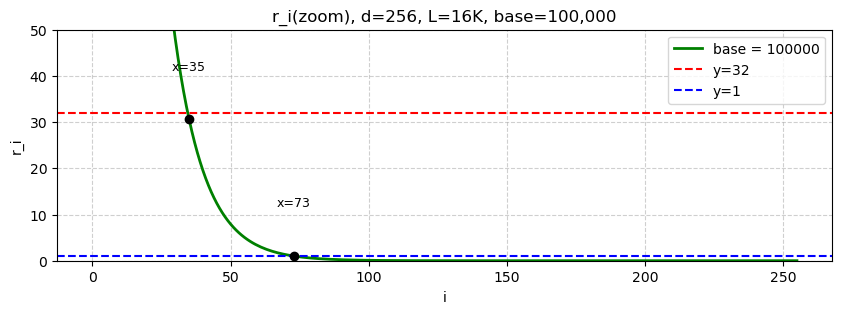

与 y=32 的交点横坐标: 35
与 y=1 的交点横坐标: 73


In [7]:
# 创建图形
plt.figure(figsize=(10, 3))
plt.plot(x.tolist(), lambda_2.tolist(), label='base = 100000', color='green', linewidth=2)
plt.axhline(y=32, color='red', linestyle='--', linewidth=1.5, label='y=32')
plt.axhline(y=1, color='blue', linestyle='--', linewidth=1.5, label='y=1')
idx_32 = torch.argmin(torch.abs(lambda_2 - 32))
idx_1 = torch.argmin(torch.abs(lambda_2 - 1))
x_32 = x[idx_32].item()
y_32 = lambda_2[idx_32].item()
x_1 = x[idx_1].item()
y_1 = lambda_2[idx_1].item()
plt.scatter([x_32, x_1], [y_32, y_1], color='black', zorder=5)
plt.text(x_32, y_32+10, f'x={x_32}', fontsize=9, ha='center', va='bottom')
plt.text(x_1, y_1+10, f'x={x_1}', fontsize=9, ha='center', va='bottom')
plt.title('r_i(zoom), d=256, L=16K, base=100,000')
plt.xlabel('i')
plt.ylabel('r_i')
plt.ylim(0,50)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print(f"与 y=32 的交点横坐标: {x_32}")
print(f"与 y=1 的交点横坐标: {x_1}")

## 插值

根据高低频点，求 gamma 插值系数

$$
\begin{align} \gamma(r) =  \begin{cases}     0, &\text{if } r < \alpha\\     1, &\text{if } r > \beta\\     \dfrac{r - \alpha}{\beta - \alpha}, &\text{otherwise}. \end{cases} \end{align} \\
$$



$$
\begin{align}     \theta'_i &= \theta_i &\quad \text{; 高频,外推}  \\     \theta'_i &=      \Big(1-\gamma\big(r_i\big)\Big) \frac{\theta_i}{s} + \gamma\big(r_i\big) \theta_i &\quad \text{;中频,混合插值} \\     \theta'_i &= \frac{\theta_i}{s} &\quad \text{; 低频,内插}  \\ \end{align} \\
$$

根据高低频点：

$$
\begin{align} \gamma(r_i) =  \begin{cases}     0, &\text{if } i > 114 & \text{;内插}\\     1, &\text{if } i < 75 & \text{;外推}\\     \dfrac{r_i - \alpha}{\beta - \alpha}, &\text{otherwise}.& \text{;混合插值} \end{cases} \end{align} \\
$$

In [8]:
def ntk_part(angle, r, low, high, alpha = 1, beta = 32, scale = 10):
    ntk_angle = angle
    pi_angle = angle / scale
    
    gamma = (r - alpha) / (beta - alpha)
    mix_angle = (1-gamma) * pi_angle + gamma * ntk_angle

    out_angle = ntk_angle.clone()
    out_angle[low:high] = mix_angle[low:high]
    out_angle[high:] = pi_angle[high:]
    return out_angle

## 动态 Scaling

在 YaRN 中提出一种 dynamic scaling 技术，能够进行外推 2x 长度。（如果模型长度为 200k， 2x外推长度增加显著）。

此特性在 Inference 中体现， 以下描述的代码可见，随文本长度变化产生 cos、sin（而**非初始化 RoPE 得到固定的 cos/sin cache值**）

```python
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
    ) -> tuple[torch.Tensor, torch.Tensor]:
        # 2️⃣ YaRN Dynamic-Scaling 技术
        num_tokens = query.shape[0]
        self.cur_context_length = num_tokens
        cos, sin = self._compute_cos_sin(num_tokens) # 随 seq_len 增长而增长

        query_shape = query.shape
        query = query.view(num_tokens, -1, self.head_dim)
        query = _apply_rotary_emb(query, cos, sin)
        query = query.reshape(query_shape)

        key_shape = key.shape
        key = key.view(num_tokens, -1, self.head_dim)
        key = _apply_rotary_emb(key, cos, sin)
        key = key.reshape(key_shape)
        return query, key
```

对于 scale 的选择有两种：

- 静态scaling因子： $s= \max(1, L'/L)$ 定义了目标长度 L', 则 s 为定值
- 动态scaling因子：$s= \max(1, l/L)$，随推理长度增长, l 不断变大，$s$ 也不断的在变化。

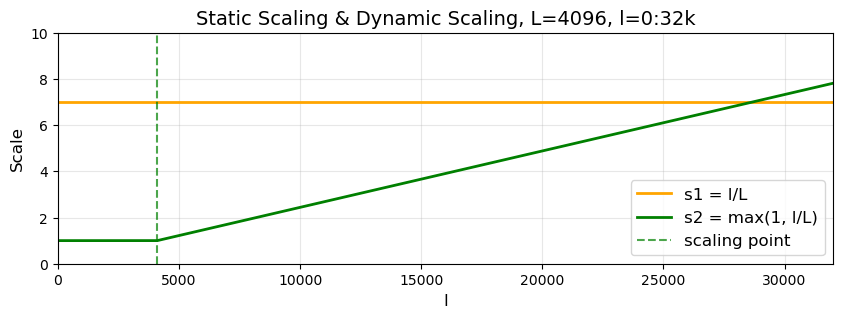

In [9]:
import numpy as np
import matplotlib.pyplot as plt
L = 4096
x = np.arange(0, 32001, 100)  # 从0到32000，步长为100
s1 = np.full_like(x, 32000 / L)  # 常数函数
s2 = np.maximum(1, x / L)  # 分段函数
plt.figure(figsize=(10, 3))
plt.plot(x, s1, label=f's1 = l/L', linewidth=2, color='orange')
plt.plot(x, s2, label='s2 = max(1, l/L)', linewidth=2, color='green')
critical_point = L  # 临界点 x = L
plt.axvline(x=critical_point, color='green', linestyle='--', alpha=0.7, label=f'scaling point')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.title('Static Scaling & Dynamic Scaling, L=4096, l=0:32k', fontsize=14)
plt.xlabel('l', fontsize=12)
plt.ylabel('Scale', fontsize=12)
plt.xlim(0, 32000)
plt.ylim(0, 10)

plt.show()

dynamic scaling 能外推的原因在于：

1. 固定的 scaling 对短距离推理不友好，比如当前为 L，目标推 2L 外推时，其位置编码是突变的。
3. dynamic scaling 短距离保持原有推理，随着长度增加，其位置编码变化是平滑的，in-context leanring 技术能够学习到逐渐外推的模型，尽管外推到一定长度失效

## YaRN 注意力分数缩放

在 long-context 问题上, 由于序列长度增加， softmax 会丧失注意力焦点，一种解决方式是增加 <1 的温度，使得注意力权重分布变 sharp

$$
\begin{equation} \text{softmax}\left(\dfrac{q_m^Tk_n}{t\sqrt{|D|}}\right). \end{equation} 
$$

其中，$\sqrt{\frac{1}{t}} = 0.1 \ln({s}) + 1=1.208 $, 下图中，随 scale 增加，温度减小，对应的分布变 sharp。突出注意力关系 QK。

在 YaRN 代码中：

```python
            concentration = (
                0.1 * math.log(self.scaling_factor) + 1.0
            )  # YaRN concentration
            print('t:',  1/concentration**2)
```

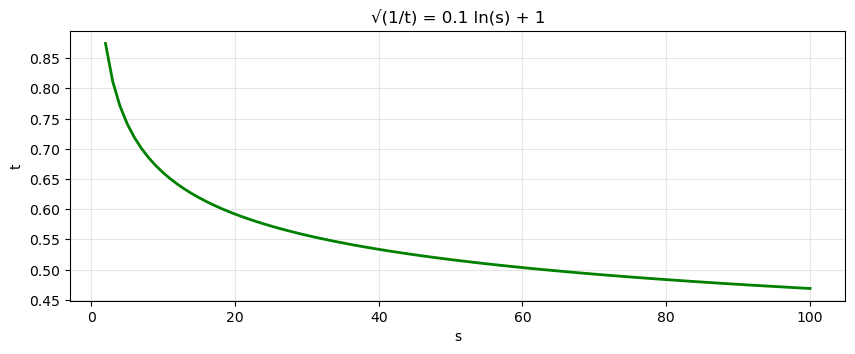

In [10]:
import numpy as np
x = np.arange(2, 101)
t_values = []
for val in x:
    if val == 1:
        # 当 x=1 时，t 趋于无穷大，我们设置为一个很大的数以便可视化
        t_values.append(1000)  # 任意大值，表示无穷大
    else:
        t_values.append(1 / (0.1 * np.log(val)+1)**2)
plt.figure(figsize=(10, 3.5))
plt.plot(x, t_values, 'g-', linewidth=2)
plt.xlabel('s')
plt.ylabel('t')
plt.title('√(1/t) = 0.1 ln(s) + 1')
plt.grid(True, alpha=0.3)
plt.show()

## 总结

1. 分段 RoPE 是找到高低频点，高频保留、低频内插、中频插值。YaRN 做到保高频的前提，在其他频上像 NTK-RoPE 一样去动态插值（维度越高，内插强度越大）
2. dynamic scaling 技术能够外推 2x 长度，能够随 context 长度，平滑缩放 RoPE。  NTK-RoPE 会有 out-of-bound 现象，动态缩放有助于模型在已见过的位置编码内进行缩放
3. yarn 缩放从注意力关系层面上，sharp 注意力分布